# Band Definitions

Neural oscillations vary in their center frequency, requiring that analyses consider individualized frequency bands. 

### Issue

Many analyses apply predefined frequency ranges for bands of interest. Such predefined ranges may not reflect the variability of individual peak frequencies that we observe in neural field data. The use of predefined band ranges can lead to misestimations of oscillatory power, if peaks are not well captured. 

### Solution

Chosen frequency ranges for analyses of interest should be validated on the data to be analyzed. In at least some cases, individualized frequency ranges may need to be used to appropriately reflect the data. 

### Related Work

The following papers include discussion of this topic:
- [EEG alpha and theta oscillations reflect cognitive and memory performance: a review and analysis](https://doi.org/10.1016/S0165-0173(98)00056-3), Klimesch, 1999
- [The increase in theta/beta ratio on resting-state EEG in boys with ADHD is mediated by slow alpha peak frequency](https://doi.org/10.1016/j.pnpbp.2010.08.004), Lansbergen et al, 2011

### Related Discussion / Examples

The following other online examples / tutorials also discuss this topic:
- Band-by-band analyses of neural field data
    - https://fooof-tools.github.io/fooof/auto_motivations/measurements/plot_BandByBand.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

from fooof.bands import Bands
from fooof.utils import trim_spectrum
from fooof.plts.spectra import plot_spectrum_shading, plot_spectra_shading

from neurodsp.sim import sim_combined, sim_oscillation, sim_powerlaw
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.utils import remove_nans, create_times, set_random_seed
from neurodsp.timefrequency import amp_by_time, freq_by_time, phase_by_time
from neurodsp.plts.time_series import plot_time_series

In [1]:
# Add path and import custom code for the project
import sys
sys.path.append('code')
from utils import compute_abs_power
from plts import plot_bar, style_psd, savefig

## Settings

In [5]:
import seaborn as sns
sns.set_context('poster')

In [6]:
# Set random seed
set_random_seed(808)

In [7]:
# Set the average function to use
#avg_func = np.nanmedian
avg_func = np.nanmean

In [8]:
# Define general simulation settings
n_seconds = 20
fs = 1000

times = create_times(n_seconds, fs)

In [9]:
# Define parameters for the simulations
exp = -1.5
ap_filt = (2, 50)

cf1 = 10
cf2 = 8
cf3 = 6

In [10]:
# Define our bands of interest
bands = Bands({'delta' : [2, 4],
               'theta' : [4, 8],
               'alpha' : [8, 13],
               'beta' : [13, 30]})

In [11]:
# Set the shading colors for plots
shade_colors = ['#e8dc35', '#46b870', '#1882d9', '#a218d9']

# 
c1 = '#0000ff'
c2 = '#00693a'

colors = [c1, c2]

In [12]:
# Define a helper function for creating signals with varying center frequencies
def get_components(cf, exp=exp, ap_filt=ap_filt):
    return {'sim_powerlaw' : {'exponent' : exp, 'f_range' : ap_filt},
            'sim_oscillation' : {'freq' : cf}}

In [13]:
# Collect parameters and set up simulations
comps1 = {'sim_powerlaw' : {'exponent' : exp, 'f_range' : ap_filt},
          'sim_oscillation' : {'freq' : cf1}}
comps2 = {'sim_powerlaw' : {'exponent' : exp, 'f_range' : ap_filt},
          'sim_oscillation' : {'freq' : cf2}}
comps3 = {'sim_powerlaw' : {'exponent' : exp, 'f_range' : ap_filt},
          'sim_oscillation' : {'freq' : cf3}}

# Define relative power of the signal components
comp_vars = [0.5, 1]

In [14]:
# Set frequency ranges of interest
psd_range = [3, 35]
alpha_range = [8, 12]

In [15]:
# Analysis settings
nperseg = 1.5 * fs

In [16]:
# Plot settings
#labels = ['sig-1', 'sig-2']
labels = ['A', 'B']

alpha_color = '#1882d9'
indi_color = '#00a645'

In [17]:
# Set whether to save out figures
SAVE_FIG = False

## Simulate Time Series

First, we'll simulate some example data. 

For this simulate we will simulate two time series, each with an oscillation in them, but with slightly different center frequencies. 

In [18]:
# Simulate AP component
ap = sim_powerlaw(n_seconds, fs, exp, f_range=ap_filt, variance=0.5)

# Simulate PE components
osc1 = sim_oscillation(n_seconds, fs, cf1)
osc2 = sim_oscillation(n_seconds, fs, cf2)

In [19]:
# 
sig1 = ap + osc1
sig2 = ap + osc2

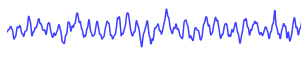

In [20]:
# Plot the first example signal
_, ax = plt.subplots(figsize=(6, 2))
plot_time_series(times, sig1, xlim=(5, 8), lw=1.5, alpha=0.75, colors=c1, ax=ax)
plt.axis('off')
savefig(SAVE_FIG, '02-ts-sig1_noax')

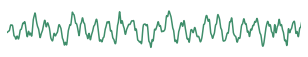

In [21]:
# Plot the second example signal
_, ax = plt.subplots(figsize=(6, 2))
plot_time_series(times, sig2, xlim=(5, 8), lw=1.5, alpha=0.75, colors=c2, ax=ax)
plt.axis('off')
savefig(SAVE_FIG, '02-ts-sig2_noax')

### Compute Power Spectra

Next, we will compute the power spectra, and compare the two signals. 

In particular, we will compare the peaks in the spectrum, to a canonically defined alpha range, shaded in blue. 

In [76]:
# Compute the power spectra of each of the example signals
freqs1, powers1 = trim_spectrum(*compute_spectrum(sig1, fs, nperseg=nperseg), psd_range)
freqs2, powers2 = trim_spectrum(*compute_spectrum(sig2, fs, nperseg=nperseg), psd_range)

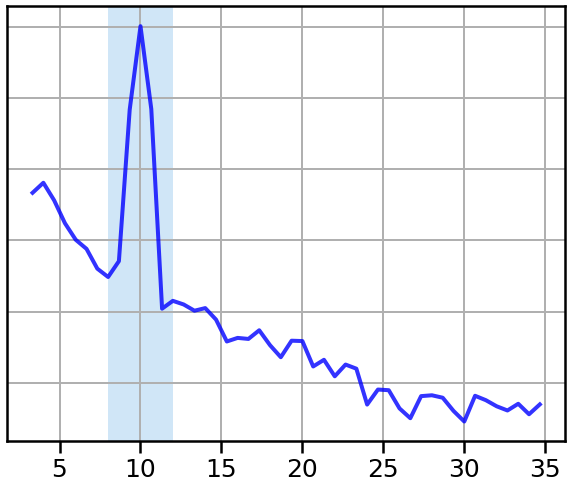

In [77]:
# Plot the power spectrum of the first signal
plot_spectrum_shading(freqs1, powers1, alpha_range, log_powers=True,
                      color=c1, alpha=0.8, lw=4, shade_colors=alpha_color)
style_psd(plt.gca())
savefig(SAVE_FIG, '02-psd_alpha_on')

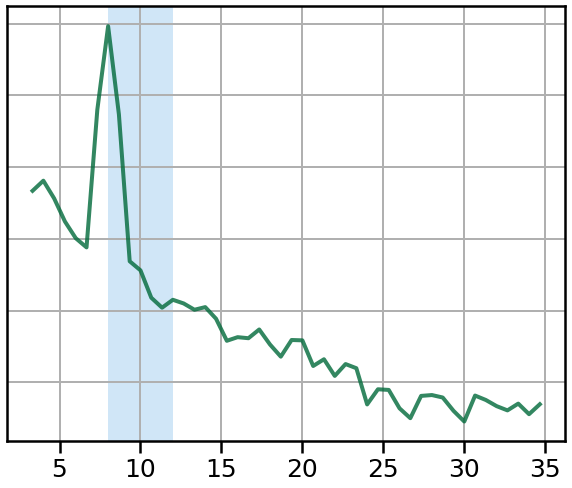

In [79]:
# Plot the power spectrum of the second signal
plot_spectrum_shading(freqs2, powers2, alpha_range, log_powers=True,
                      color=c2, alpha=0.8, lw=4, shade_colors=alpha_color)
style_psd(plt.gca())
savefig(SAVE_FIG, '02-psd_alpha_off')

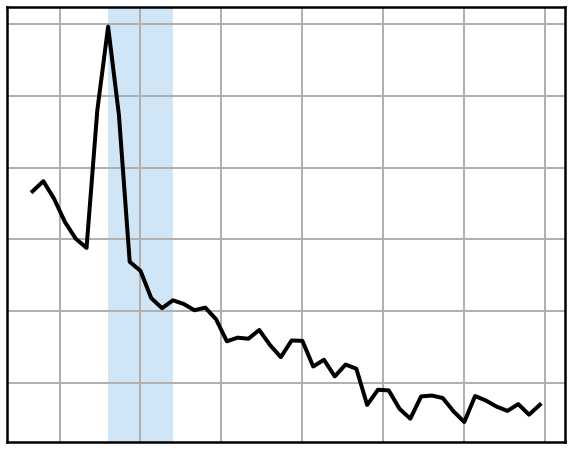

In [81]:
 # Second signal, D plot
plot_spectrum_shading(freqs2, powers2, alpha_range, log_powers=True,
                      color='black', lw=4, shade_colors=alpha_color)

style_psd(plt.gca(), clear_x=True)
savefig(SAVE_FIG, '02-psd_small_can')

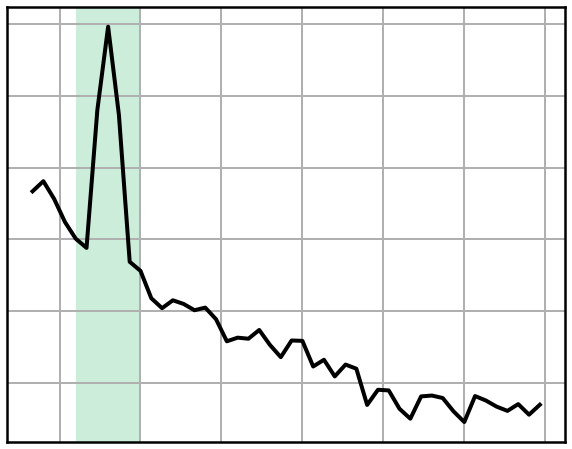

In [83]:
# Plot the individualized range of the second signal
plot_spectrum_shading(freqs2, powers2, [cf2-2, cf2+2], log_powers=True,
                      color='black', lw=4, shade_colors=indi_color)
style_psd(plt.gca(), clear_x=True)
savefig(SAVE_FIG, '02-psd_small_indi')

In [84]:
cal1 = compute_abs_power(freqs1, powers1, bands.alpha)
cal2 = compute_abs_power(freqs2, powers2, bands.alpha)

In [28]:
print(cal1, cal2)

1.6139227826093454 1.2782299865069513


In [29]:
ial1 = compute_abs_power(freqs1, powers1, [cf1-2, cf1+2])
ial2 = compute_abs_power(freqs2, powers2, [cf2-2, cf2+2])

In [30]:
print(ial1, ial2)

1.6027163158118507 1.5426318246925421


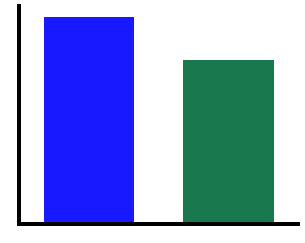

In [31]:
# Compare the measured power, using the canoncal alpha range
plot_bar(cal1, cal2, color=colors, alpha=0.9, figsize=(5, 4))
savefig(SAVE_FIG, '02-can_alpha')

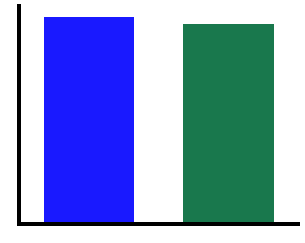

In [32]:
# individualized alpha
plot_bar(ial1, ial2, color=colors, alpha=0.9, figsize=(5, 4))
savefig(SAVE_FIG, '02-ind_alpha_on')

In [33]:
# canonical theta & beta
cth1 = compute_abs_power(freqs1, powers1, bands.theta)
cth2 = compute_abs_power(freqs2, powers2, bands.theta)

cbe1 = compute_abs_power(freqs1, powers1, bands.beta)
cbe2 = compute_abs_power(freqs2, powers2, bands.beta)

In [34]:
print(cth1, cth2)
print(cbe1, cbe2)

0.2795144761101111 1.4513050867878616
0.12233615661885829 0.12233615661885831


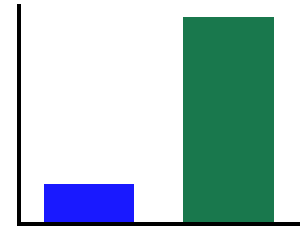

In [35]:
# Plot canonical theta
plot_bar(cth1, cth2, color=colors, alpha=0.9, figsize=(5, 4))
savefig(SAVE_FIG, '02-can_theta')

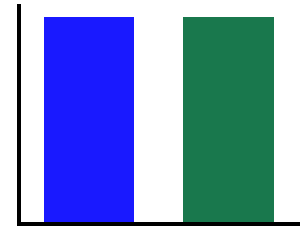

In [36]:
# Plot canonical beta
plot_bar(cbe1, cbe2, color=colors, alpha=0.9, figsize=(5, 4))
savefig(SAVE_FIG, '02-can_beta')

In [37]:
# individualized theta & beta
ith1 = compute_abs_power(freqs1, powers1, [cf1-6, cf1-2])
ith2 = compute_abs_power(freqs2, powers2, [cf2-6, cf2-2])

ibe1 = compute_abs_power(freqs1, powers1, [cf1+3, cf1+20])
ibe2 = compute_abs_power(freqs2, powers2, [cf2+3, cf2+20])

In [38]:
print(ith1, ith2)
print(ibe1, ibe2)

0.2795144761101111 0.28277529896281056
0.12233615661885829 0.1497336662192729


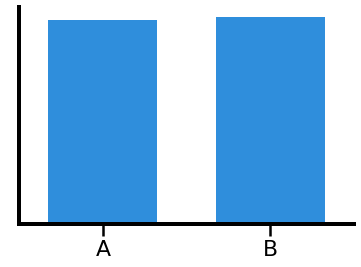

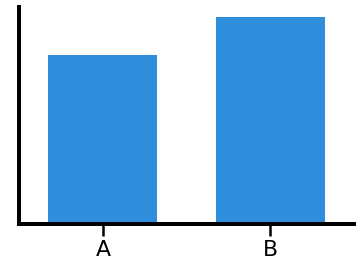

In [39]:
plot_bar(ith1, ith2, *labels, color=alpha_color, alpha=0.9)
plot_bar(ibe1, ibe2, *labels, color=alpha_color, alpha=0.9)

### Run 'Group' Analysis

Run an analysis, simulating a 'group' comparison, comparing between signals with different center frequencies. 

In [40]:
# Set a number of simulations to run & compare
n_sims = 20

In [41]:
# Initialize variables to store computed measures
cal1, cal2 = [], []
ial1, ial2 = [], []

# Simulate a 'group' comparison
for ind in range(n_sims):
    
    cur_freqs1, cur_powers1 = compute_spectrum(\
        sim_combined(n_seconds, fs, comps1, comp_vars), fs, nperseg=fs)
    cur_freqs2, cur_powers2 = compute_spectrum(\
        sim_combined(n_seconds, fs, comps2, comp_vars), fs, nperseg=fs)
    
    cal1.append(avg_func(trim_spectrum(cur_freqs1, cur_powers1, alpha_range)[1]))
    cal2.append(avg_func(trim_spectrum(cur_freqs2, cur_powers2, alpha_range)[1]))
    
    ial1.append(avg_func(trim_spectrum(cur_freqs1, cur_powers1, [cf1-2, cf1+2])[1]))
    ial2.append(avg_func(trim_spectrum(cur_freqs2, cur_powers2, [cf2-2, cf2+2])[1]))

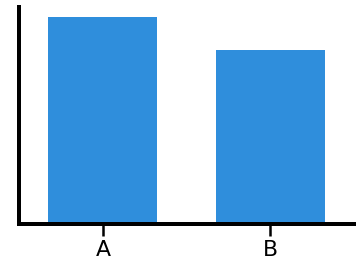

In [42]:
# Compare the measured power, using the canoncal alpha range
plot_bar(cal1, cal2, *labels, color=alpha_color, alpha=0.9)
savefig(SAVE_FIG, '02-bar_canalpha')

In [43]:
# Compute a t-test comparison of the groups, using the canoncal alpha range
print('T-test - t-val: {:1.3f}, p-val: {:1.5f}'.format(*ttest_ind(cal1, cal2)))

T-test - t-val: 14.455, p-val: 0.00000


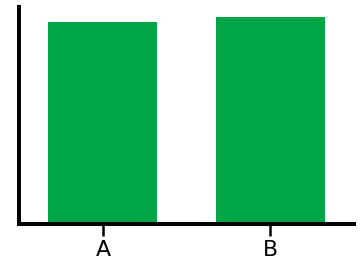

In [44]:
# Compare the measured power, using individualized alpha range
plot_bar(ial1, ial2, *labels, color=indi_color)
savefig(SAVE_FIG, '02-bar_actalpha')

In [45]:
# Compute a t-test comparison of the groups, using individualized alpha range
print('T-test comparison - t-val: {:1.3f}, p-val: {:1.5f}'.format(*ttest_ind(ial1, ial2)))

T-test comparison - t-val: -2.080, p-val: 0.04433


## Compare Filtered Signals

Another way we can compare the impacts of differences in center frequencies is by looking at filtered data. 

Here, we will filter the signals, using canonical and individualized frequency ranges. 

Note that for the first signal, the canonical and individualized range are equivalent, so we will only show one. 

In [46]:
# Filter signals into the alpha range, including an individualized range
sig_filt1 = filter_signal(sig1, fs, 'bandpass', alpha_range)
sig_filt2 = filter_signal(sig2, fs, 'bandpass', alpha_range)
#sig_filt3 = filter_signal(sig3, fs, 'bandpass', alpha_range)

#
sig_filt2_ind = filter_signal(sig2, fs, 'bandpass', [cf2-2, cf2+2])
#sig_filt3_ind = filter_signal(sig3, fs, 'bandpass', [cf3-2, cf3+2])

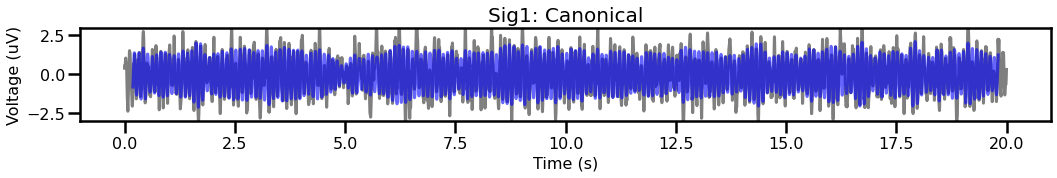

In [47]:
# Plot the first signal, with the corresponding filtered trace
plot_time_series(times, [sig1, sig_filt1], title='Sig1: Canonical',
                 colors=['k', 'b'], alpha=[0.5, 0.6], ylim=[-3, 3])

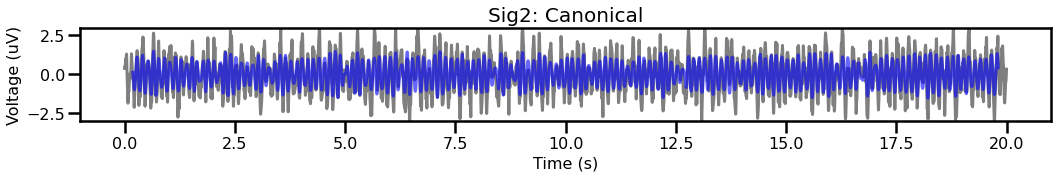

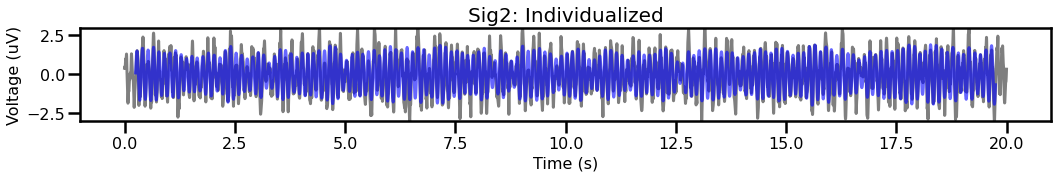

In [48]:
# Compare the filtered traces for signal 2, between canonical & individualized
plot_time_series(times, [sig2, sig_filt2], title='Sig2: Canonical',
                 colors=['k', 'b'], alpha=[0.5, 0.6], ylim=[-3, 3])
plot_time_series(times, [sig2, sig_filt2_ind], title='Sig2: Individualized',
                 colors=['k', 'b'], alpha=[0.5, 0.6], ylim=[-3, 3])

For the second signal, comparing canonical and individualized ranges shows that the individualized range captures more of the data. 

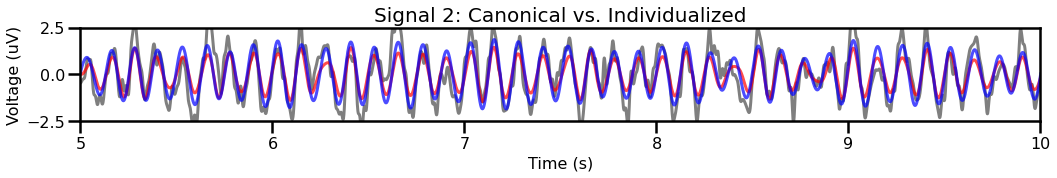

In [49]:
# Zoom in & compare within the second signal between canonical & individualized
title = "Signal 2: Canonical vs. Individualized"
plot_time_series(times, [sig2, sig_filt2, sig_filt2_ind], title=title,
                 colors=['k', 'r', 'b'], alpha=[0.5, 0.7, 0.7],
                 xlim=[5, 10], ylim=[-2.5, 2.5])

In [50]:

# title = "XX"
# plot_time_series(times, [sig_filt1, sig_filt2, sig_filt3], title=title,
#                  colors=['k', 'r', 'b'], alpha=[0.5, 0.7, 0.7],
#                  xlim=[5, 10], ylim=[-2.5, 2.5])

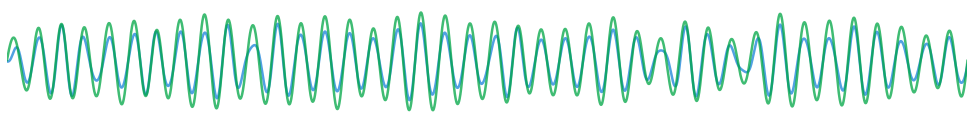

In [51]:
plot_time_series(times, [sig_filt2, sig_filt2_ind],
                 colors=[alpha_color, indi_color], lw=2.5,
                 alpha=0.75, xlim=[5, 10])
plt.axis('off');
savefig(SAVE_FIG, '02-ts-filt')

In [52]:
#plot_time_series(times, [sig_filt3, sig_filt3_ind], xlim=[5, 10])

## Compare Instantaneous Measures

Finally, to quantify our comparisons from the filter examples, we can use instantaneous measures. 

Here, we will compute amplitude and frequency measures, and compare the average results. 

In [53]:
# Calculate instanenous measures of amplitude
amp1 = amp_by_time(sig_filt1, fs)
amp2 = amp_by_time(sig_filt2, fs)
amp2_ind = amp_by_time(sig_filt2_ind, fs)

In [54]:
# Check measures of instantaneous amplitude
print('Avg amp: Sig1 (canonical):  \t {:1.4f}'.format(avg_func(amp1)))
print('Avg amp: Sig2 (canonical):  \t {:1.4f}'.format(avg_func(amp2)))
print('Avg amp: Sig2 (individual): \t {:1.4f}'.format(avg_func(amp2_ind)))

Avg amp: Sig1 (canonical):  	 1.4289
Avg amp: Sig2 (canonical):  	 1.0091
Avg amp: Sig2 (individual): 	 1.4139


Again, we can see that the alpha measures are equivalent when individualized (but different with the canonical range). 

In [55]:
# Calculate instanenous measures of frequency
fre1 = freq_by_time(sig_filt1, fs)
fre2 = freq_by_time(sig_filt2, fs)
fre2_ind = freq_by_time(sig_filt2_ind, fs)

In [56]:
# Check measures of instantaneous frequency
print('True freq - sig1: \t\t{:1.2f}'.format(cf1))
print('Avg  freq - sig1 (canonical):  \t {:1.2f}'.format(avg_func(fre1)))
print('True freq - sig2:  \t\t {:1.2f}'.format(cf2))
print('Avg  freq - sig2 (canonical):  \t {:1.2f}'.format(avg_func(fre2)))
print('Avg  freq - sig2 (individual): \t {:1.2f}'.format(avg_func(fre2_ind)))

True freq - sig1: 		10.00
Avg  freq - sig1 (canonical):  	 10.03
True freq - sig2:  		 8.00
Avg  freq - sig2 (canonical):  	 8.00
Avg  freq - sig2 (individual): 	 8.00


Individualized frequency measures can only measure frequencies within the narrow-band band range they see.

This means they can be biased if the true frequencies at at or near the edge of this range, as we can see in the above. 

In [57]:
print(np.nanstd(fre1))
print(np.nanstd(fre2))

1.6684539711261577
0.7048979127447279


In [58]:
from scipy.stats import sem

In [59]:
print(sem(fre1, nan_policy='omit'))
print(sem(fre2, nan_policy='omit'))

0.011910845581697162
0.00503216171069801


In [60]:
theta_range = (4, 8)
beta_range = (13, 30)

In [61]:
cfs = [6, 7, 8, 9, 10, 11, 12, 13, 14]

In [62]:

outs_can = []
outs_ind = []
powers = []

ths = []
bes = []

for cf in cfs:
    
    sig = sim_combined(n_seconds, fs, get_components(cf), comp_vars)
    
    _, pows = trim_spectrum(*compute_spectrum(sig, fs, nperseg=nperseg), psd_range)
    powers.append(pows)
    
    amp_can = amp_by_time(sig, fs, alpha_range)
    amp_ind = amp_by_time(sig, fs, [cf-2, cf+2])
    
    outs_can.append(avg_func(amp_can))
    outs_ind.append(avg_func(amp_ind))
    
    ths.append(avg_func(amp_by_time(sig, fs, theta_range)))
    bes.append(avg_func(amp_by_time(sig, fs, beta_range)))

/Users/tom/opt/anaconda3/lib/python3.8/site-packages/neurodsp/filt/checks.py:172: UserWarning: Transition bandwidth is  4.0  Hz. This is greater than the desiredpass/stop bandwidth of  4.0 Hz
  warn('Transition bandwidth is  {:.1f}  Hz. This is greater than the desired'\


In [63]:
ms = 18

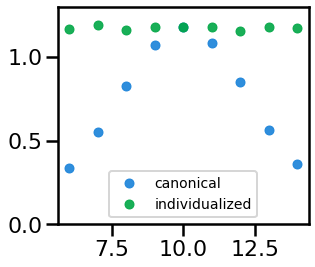

In [64]:
_, ax = plt.subplots(figsize=(4.5, 4))
ax.plot(cfs, outs_can, '.', ms=ms, alpha=0.9, color=alpha_color, label='canonical')
ax.plot(cfs, outs_ind, '.', ms=ms, alpha=0.9, color=indi_color, label='individualized')
ax.set_ylim([0, 1.30]);
plt.legend(loc=8, prop={'size': 14})
savefig(SAVE_FIG, '02-alpha_power')

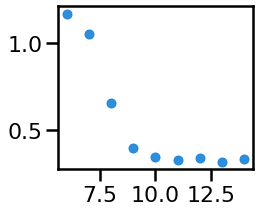

In [65]:
_, ax = plt.subplots(figsize=(3.5, 3))
ax.plot(cfs, ths, '.', ms=ms, alpha=0.9, color=alpha_color)
savefig(SAVE_FIG, '02-theta_power')

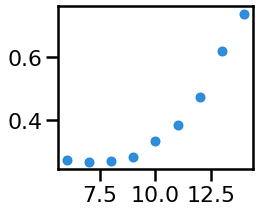

In [66]:
_, ax = plt.subplots(figsize=(3.5, 3))
ax.plot(cfs, bes, '.', ms=ms, alpha=0.9, color=alpha_color)
savefig(SAVE_FIG, '02-beta_power')

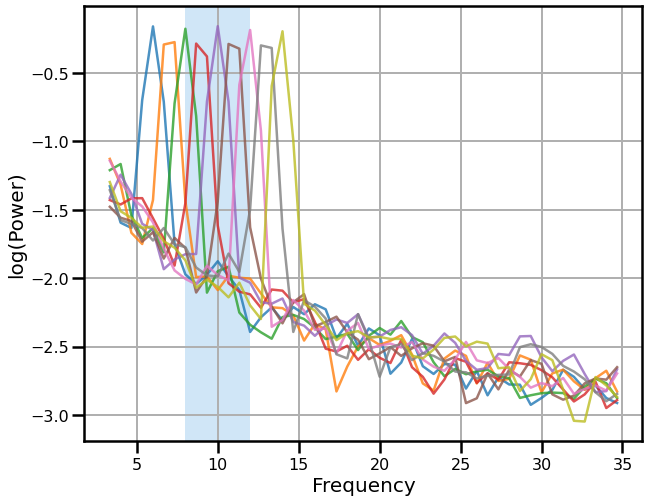

In [67]:
plot_spectra_shading(freqs1, powers, alpha_range, alpha_color,
                     lw=2.5, log_powers=True, alpha=0.8)
savefig(SAVE_FIG, '02-psds_all')

## Conclusion

Neural oscillations are often analyzed using pre-defined band ranges of interest.

Here, we have explored a series of limitations whereby if these ranges do not appropriately reflect the actual center frequencies of the data, then measures of interest may be confounded, for example, differences in center frequency can be look like a difference in power. 

Chosen frequency ranges should always be validated on the data to be analyzed. In some cases, individualized frequency ranges may be required in order to better capture the data. 